In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-plot

In [ ]:
# Import the required libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Read the data
data = pd.read_csv('/content/drive/MyDrive/Text classification using Random Forest/data.csv')
data.head()

,Unnamed: 0,Unnamed: 0.1,ID,OID,Date,Relevance,Text,Geo,Place,Unnamed: 4,98136,9.9724844744185E+017,5ec248621c9b498cdbf214f9,2018-05-17 22:52:12+00:00,ôüí´©å ôç£huge eruption at hawaii's kilauea volcanoôçø\n\nhttps://t.co/4spppy6s4s,Unnamed: 5,Unnamed: 6,1,Unnamed: 8
0,0,42279.0,1.005710e+18,5ec248611c9b498cdbf13ac8,2018-06-10 07:08:50+00:00,0.0,"""why is guatemalaôçös volcano deadlier than ha...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,115620.0,9.957570e+17,5ec24b1c7e6c5671a017d5d6,2018-05-13 20:06:37+00:00,1.0,@cnn #news- new crack from hawaii volcano is s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,155248.0,9.922960e+17,5ec24b1c7e6c5671a01870a2,2018-05-04 06:54:01+00:00,1.0,i liked a @youtube video https://t.co/hz73xihp...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,23626.0,1.013800e+18,5ec248611c9b498cdbf0f1eb,2018-07-02 15:10:38+00:00,1.0,news alert - hawaii's kilauea volcano is a dis...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,139689.0,9.930930e+17,5ec24b1c7e6c5671a01833db,2018-05-06 11:40:41+00:00,1.0,#kilauea #volcano eruption on #hawaii there is...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.shape

(3227, 19)

In [ ]:
# Check missing values
data.isnull().sum()

Unnamed: 0                                                                              0
Unnamed: 0.1                                                                          227
ID                                                                                    227
OID                                                                                   227
Date                                                                                  227
Relevance                                                                            1227
Text                                                                                  227
Geo                                                                                  3216
Place                                                                                3159
Unnamed: 4                                                                           2227
98136                                                                                3000
9.97248447

Both Text & Relevance columns contain null values.

In [ ]:
#select only text & relevence columns
df = data[['Text', 'Relevance']]

# Drop null values 
df = df.dropna()

# Type conversion 
df['Relevance'] = df['Relevance'].astype(int)

df.head()

,Text,Relevance
0,"""why is guatemalaôçös volcano deadlier than ha...",0
1,@cnn #news- new crack from hawaii volcano is s...,1
2,i liked a @youtube video https://t.co/hz73xihp...,1
3,news alert - hawaii's kilauea volcano is a dis...,1
4,#kilauea #volcano eruption on #hawaii there is...,1


In [ ]:
df.shape

(2000, 2)

**Data preprocessing:**

In [ ]:
import string
punct_to_remove = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', punct_to_remove))

In [ ]:
#Download stopwords from nltk libraries
import nltk
nltk.download('stopwords')
STOPWORDS = set(nltk.corpus.stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Download wordnet from nltk library
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
import re
def preprocess_data(text):
  # Lower case the text
  text = text.lower()
  # Remove white spaces
  text = text.strip()
  # Remove links
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  # Removing punctuations
  text = remove_punctuation(text)
  # Removing stop words 
  text = remove_stopwords(text)
  # Perform Lemmatization
  text = lemmatize_words(text)
  return text 

df['Text'] = df['Text'].apply(preprocess_data)

In [ ]:
df.head()

,Text,Relevance
0,guatemalaôçös volcano deadlier hawaiiôçös neet...,0
1,cnn news new crack hawaii volcano spewing lava...,1
2,liked youtube video httpstcohz73xihpcs lava re...,1
3,news alert hawaii kilauea volcano disaster end...,1
4,kilauea volcano eruption hawaii way everything...,1


**How classes are distributed in train data?**

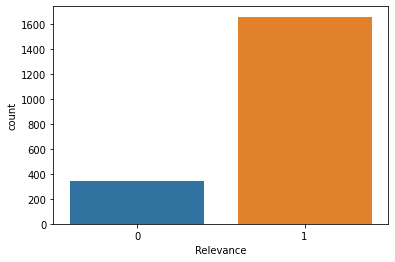

In [ ]:
sns.countplot(df.Relevance)

In [ ]:
df.Relevance.value_counts()

1    1657
0     343
Name: Relevance, dtype: int64

Data is highly imbalanced. Relevance samples are more than the Non-relevance samples.

**Training/Test split**

In [ ]:
# Split the data into train(80%) & test(20%) sets 
x_train, x_test, y_train, y_test = train_test_split(df['Text'], df['Relevance'], test_size=0.2, random_state=42)

print(f'Train shape : {x_train.shape}')
print(f'Test shape : {x_test.shape}')

Train shape : (1600,)
Test shape : (400,)


**Tokenizaton & Vectorization**

In [ ]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (2, 2)   # Bigram

# Limit on the number of features. We use the top 10K features.
TOP_K = 10000

def ngram_vectorize(train_texts, train_labels, test_texts, tfidf:bool = None):
    """Vectorizes texts as n-gram vectors.
    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    if tfidf:
      # TFIDF
      vectorizer = TfidfVectorizer(ngram_range = NGRAM_RANGE, dtype='int32')
      x_train = vectorizer.fit_transform(train_texts)
      x_test = vectorizer.transform(test_texts)
      feature_names = vectorizer.get_feature_names()
    else:
      # CountVectorizer
      vectorizer = CountVectorizer(ngram_range = NGRAM_RANGE, dtype='int32')
      x_train = vectorizer.fit_transform(train_texts)
      x_test = vectorizer.transform(test_texts)
      feature_names = vectorizer.get_feature_names()

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)

    mask = selector.get_support() #list of booleans
    new_features = [] # The list of your K best features

    for bool, feature in zip(mask, feature_names):
      if bool:
        new_features.append(feature)
    # Transform to top 'k' of the vectorized features
    x_train = selector.transform(x_train).astype('float32')
    x_test = selector.transform(x_test).astype('float32')
    return x_train, x_test, new_features

## Count Vectorization

In [ ]:
X_train, X_test, selected_features = ngram_vectorize(x_train, y_train, x_test)

**Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

Using training data perform k-fold cross-validation using Grid Search.

In [ ]:
%%time
#Initialize the Random Forest classifier
estimator1 = RandomForestClassifier(random_state=42)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2,20), 
              'min_samples_split' : [2, 3, 5, 10, 12],
              'n_estimators' : [10, 20, 50,100, 120],
              'class_weight' : ['balanced', 'balanced_subsample']
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(estimator1, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

print('Best parameters are:')
print(grid_obj.best_params_)

Best parameters are:
{'class_weight': 'balanced_subsample', 'max_depth': 18, 'min_samples_split': 2, 'n_estimators': 100}
CPU times: user 14min 3s, sys: 3.16 s, total: 14min 6s
Wall time: 14min 5s


In [ ]:
# Fit the model using above parameters
rf_cv = RandomForestClassifier(max_depth=18, min_samples_split=2, n_estimators=100, class_weight='balanced_subsample', random_state=42)
rf_cv.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=18, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

### Feature importances for CountVectorization

In [ ]:
rf_cv.feature_importances_

array([0.        , 0.00062739, 0.00042044, ..., 0.        , 0.        ,
       0.        ])

In [ ]:
selected_features[:10]

['01 mile',
 '021041 local',
 '021041 onto',
 '07062018 021041',
 '10 2018',
 '10 sticker',
 '10 worst',
 '10 year',
 '100 foot',
 '100 home']

In [ ]:
# Get top 50 features 
feature_cv = pd.DataFrame(rf_cv.feature_importances_, columns=['Feature_importance'])
feature_cv['Features'] = selected_features
feature_cv = feature_cv.sort_values(by = 'Feature_importance', ascending=False).reset_index(drop=True)
feature_cv.head()

,Feature_importance,Features
0,0.045403,kilauea volcano
1,0.021949,hawaii kilauea
2,0.020916,volcano eruption
3,0.017010,lava flow
4,0.015887,volcano erupts


Text(0.5, 1.0, 'Top 50 features')

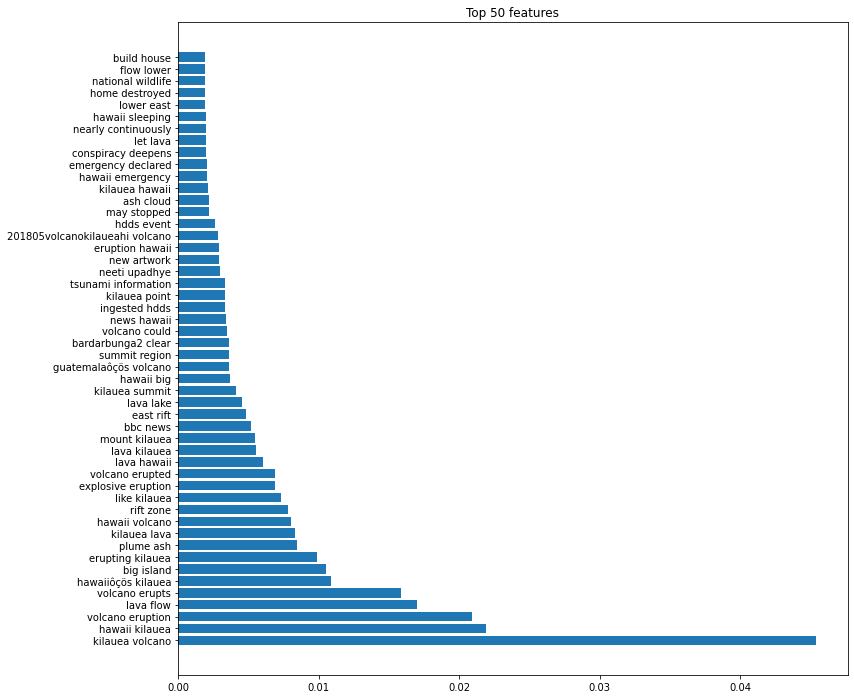

In [ ]:
# Top 50 features
top_50_cv = feature_cv[:50]

# Plot feature importances 
plt.figure(figsize = (12, 12))
plt.barh(top_50_cv.Features, top_50_cv.Feature_importance)
plt.title('Top 50 features')

In [ ]:
# Get predictions 
y_pred = rf_cv.predict(X_test)

In [ ]:
# Calculate metrics
acc_score = metrics.accuracy_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')
precision = metrics.precision_score(y_test, y_pred, average='weighted')

print(f'Accuracy : {acc_score:.3}')
print(f'F1-score : {f1:.3}')
print(f'Recall : {recall:.3}')
print(f'Precision : {precision:.3}')

Accuracy : 0.825
F1-score : 0.777
Recall : 0.825
Precision : 0.806


**Confusion matrix**

In [ ]:
from scikitplot.metrics import plot_confusion_matrix

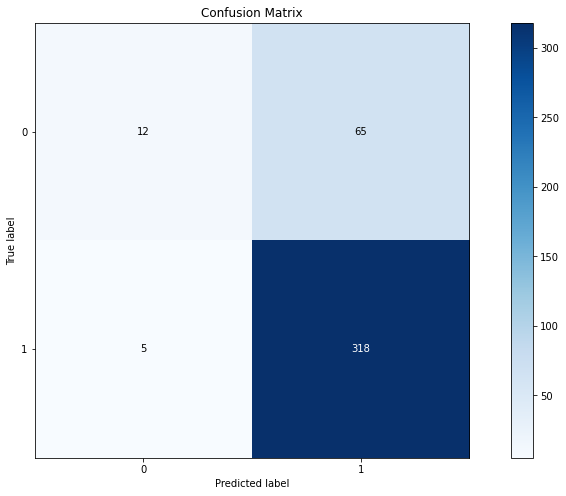

In [ ]:
#Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=False,figsize=(15,8))

**Classification Report:**

In [ ]:
class_report = metrics.classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.71      0.16      0.26        77
           1       0.83      0.98      0.90       323

    accuracy                           0.82       400
   macro avg       0.77      0.57      0.58       400
weighted avg       0.81      0.82      0.78       400



**Plot ROC curve**

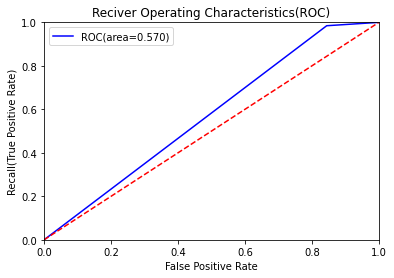

AUC: 0.5701821398415826


In [ ]:
#ROC_AUC curve
plt.figure()
false_positive_rate, recall, thresholds=metrics.roc_curve(y_test, y_pred)
roc_auc=metrics.auc(false_positive_rate, recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate, recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

## TFIDF Vectorization

In [ ]:
X_train, X_test, selected_features_tfidf = ngram_vectorize(x_train, y_train, x_test, tfidf=True)

Cross validation using Grid Search

In [ ]:
%%time
#Initialize the Random Forest classifier
estimator2 = RandomForestClassifier(random_state=42)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2,20), 
              'min_samples_split' : [2, 3, 5, 10, 12],
              'n_estimators' : [10, 20, 50,100, 120],
              'class_weight' : ['balanced', 'balanced_subsample']
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(estimator2, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

print('Best parameters are:')
print(grid_obj.best_params_)

Best parameters are:
{'class_weight': 'balanced', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 120}
CPU times: user 14min 18s, sys: 3.19 s, total: 14min 21s
Wall time: 14min 21s


In [ ]:
# Fit the model using above parameters
rf_tfidf = RandomForestClassifier(max_depth=15, min_samples_split=2, n_estimators=120, class_weight='balanced', random_state=42)
rf_tfidf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### Feature importances for TFIDFVectorization

In [ ]:
rf_tfidf.feature_importances_

array([0.        , 0.        , 0.00047602, ..., 0.        , 0.00041737,
       0.        ])

In [ ]:
selected_features_tfidf[:10]

['006 circas',
 '01 mile',
 '021041 local',
 '021041 onto',
 '03 june',
 '04 2018',
 '07062018 021041',
 '0758am via',
 '10 2018',
 '10 fissure']

In [ ]:
# Get top 50 features 
feature_tfidf = pd.DataFrame(rf_tfidf.feature_importances_, columns=['Feature_importance'])
feature_tfidf['Features'] = selected_features_tfidf
feature_tfidf = feature_tfidf.sort_values(by = 'Feature_importance', ascending=False).reset_index(drop=True)
feature_tfidf.head()

,Feature_importance,Features
0,0.068042,kilauea volcano
1,0.037435,hawaii kilauea
2,0.024593,volcano eruption
3,0.022354,volcano erupts
4,0.018468,lava flow


Text(0.5, 1.0, 'Top 50 features')

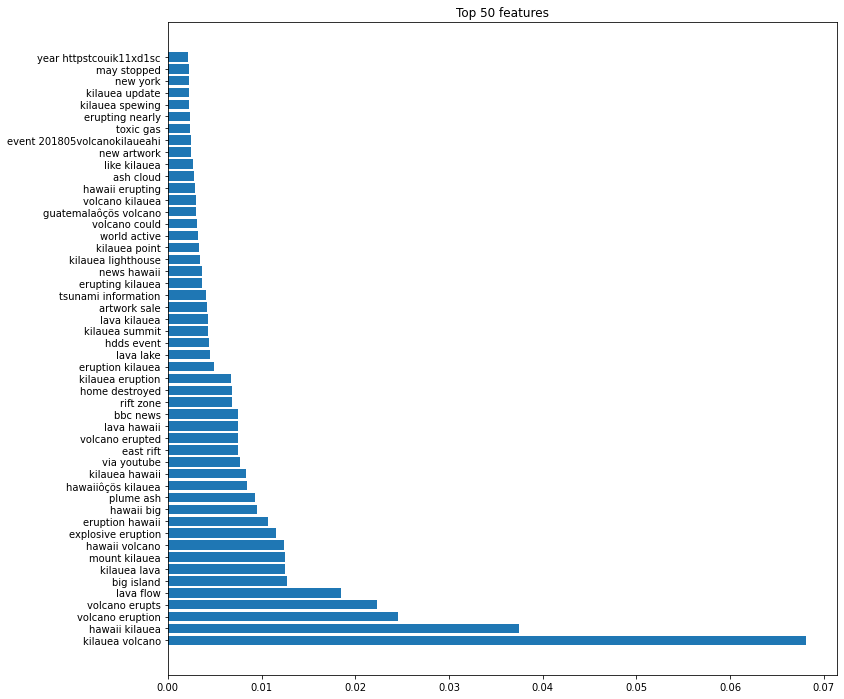

In [ ]:
# Top 50 features
top_50_tfidf = feature_tfidf[:50]

# Plot feature importances 
plt.figure(figsize = (12, 12))
plt.barh(top_50_tfidf.Features, top_50_tfidf.Feature_importance)
plt.title('Top 50 features')

In [ ]:
# Get predictions 
y_pred = rf_tfidf.predict(X_test)

In [ ]:
# Calculate metrics
acc_score = metrics.accuracy_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')
precision = metrics.precision_score(y_test, y_pred, average='weighted')

print(f'Accuracy : {acc_score:.3}')
print(f'F1-score : {f1:.3}')
print(f'Recall : {recall:.3}')
print(f'Precision : {precision:.3}')

Accuracy : 0.743
F1-score : 0.765
Recall : 0.743
Precision : 0.815


**Confusion matrix**

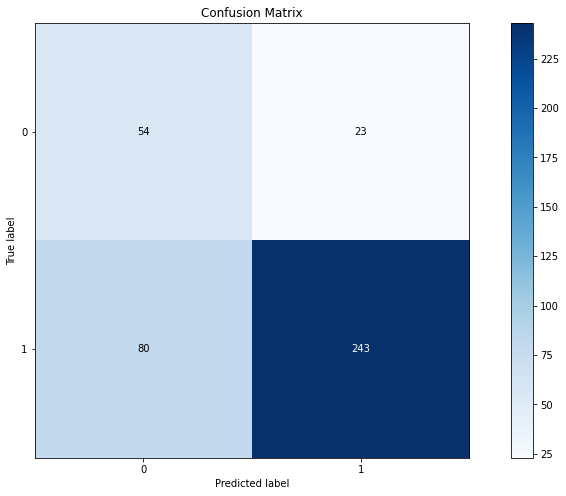

In [ ]:
#Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=False,figsize=(15,8))

**Classification Report:**

In [ ]:
class_report = metrics.classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.40      0.70      0.51        77
           1       0.91      0.75      0.83       323

    accuracy                           0.74       400
   macro avg       0.66      0.73      0.67       400
weighted avg       0.82      0.74      0.76       400



**Plot ROC curve**

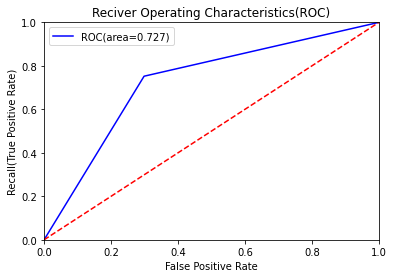

AUC: 0.726810341361425


In [ ]:
#ROC_AUC curve
plt.figure()
false_positive_rate, recall, thresholds=metrics.roc_curve(y_test, y_pred)
roc_auc=metrics.auc(false_positive_rate, recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate, recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)